In [20]:
import keras.backend as K
from keras.layers import GaussianNoise, Input, Dense, Conv2D, ReLU, LeakyReLU, MaxPooling2D, UpSampling2D, Conv2DTranspose, Reshape, Flatten, Activation, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.engine.network import Network
from keras.optimizers import RMSprop
from keras.models import Model
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import neptune
import scipy
from tqdm import tqdm_notebook as tqdm
import math
import glob
import cv2
import pdb

In [3]:
neptune.set_project('willianw/kuzushiji-dcgan')

Project(willianw/kuzushiji-dcgan)

In [4]:
IMG_SHAPE = (28, 28)

In [5]:
X = np.concatenate([np.load('input/%s-%s-imgs.npz'%(dset, kind))['arr_0'] for dset in ['k49', 'kmnist'] for kind in ['train', 'test']])                          
X2 = np.array([cv2.resize(cv2.imread(x, cv2.IMREAD_GRAYSCALE),(28,28), interpolation=cv2.INTER_NEAREST) for x in tqdm(glob.glob('input/kkanji/*/*'))])
X = np.concatenate([X, X2])/255
X = X.reshape(X.shape + (1,))
X = 2*(X - 0.5)
del X2

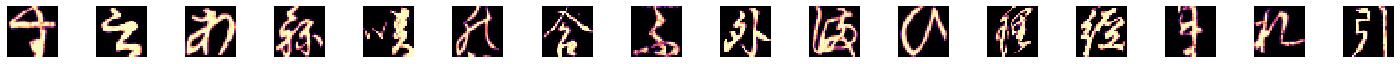

In [6]:
def print_sample_images(n=16):
    sample = np.random.choice(range(X.shape[0]), n)
    plt.subplots(1, n, figsize=(20,1))
    for i, img in enumerate(sample):
        plt.subplot(1, n, i+1)
        plt.imshow(X[sample[i]].reshape(IMG_SHAPE), cmap='magma')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
print_sample_images()

# Augmentation

In [7]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    samplewise_center=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    zca_whitening=False,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=None,
    shear_range=0,
    zoom_range=0.1,
    fill_mode='constant',
    cval=X.min(),
    horizontal_flip=False,
    vertical_flip=False,
    preprocessing_function=None,
    data_format=None,
    validation_split=None
)

In [8]:
datagen.fit(X)

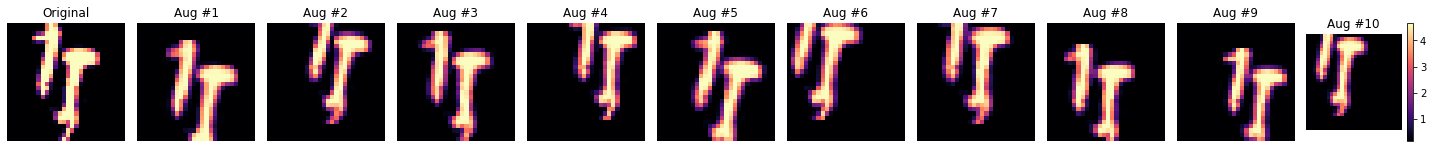

In [9]:
def view_aug(x, n=10):
    print
    plt.subplots(1, n+1, figsize=(20,2))
    for i in range(n+1):
        aug = x if i==0 else next(datagen.flow(np.array([x]), np.array([0]), batch_size=1))[0][0]
        plt.subplot(1, n+1, i+1)
        plt.imshow(aug.reshape(IMG_SHAPE), cmap='magma')
        plt.title("Original" if i==0 else "Aug #%s"%i)
        plt.axis('off')
    plt.tight_layout()
    plt.colorbar()
    plt.show()

view_aug(X[np.random.randint(0, X.shape[0])])

In [18]:
def discriminator(imshape):
    i = Input(imshape)
    x = GaussianNoise(0.2)(i)
    for n in range(2):
        x = Conv2D(imshape[-1]*(2 ** n), 5, strides=4, padding='same')(x)
        x = GaussianNoise(0.2)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.5)(x)
    x = Flatten()(x)
    o = Dense(1, activation='sigmoid')(x)
    return Model(i, o)

In [37]:
def generator(noise_shape, imshape):
    i = Input(noise_shape)
    shape0 = (imshape[0]//4, imshape[1]//4, imshape[2]*256)
    
    x = Dense(shape0[0]*shape0[1]*shape0[2])(i)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Reshape(shape0)(x)
    
    x = GaussianNoise(0.2)(x)
    x = Conv2DTranspose(int(shape0[-1]/2), 5, strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)
    
    x = GaussianNoise(0.2)(x)
    x = Conv2DTranspose(int(shape0[-1]/4), 5, strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)
    
    x = GaussianNoise(0.2)(x)
    x = Conv2DTranspose(int(shape0[-1]/8), 5, strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.3)(x)
    
    x = GaussianNoise(0.2)(x)
    x = Conv2DTranspose(1, 5, padding='same')(x)
    x = BatchNormalization()(x)
    o = Activation('tanh')(x)
    
    return Model(i, o)

In [12]:
X_full = X
X = X_full[:len(X_full) // 10].copy()

In [24]:
def r2(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [41]:
class GAN:
    def __init__(self, imshape=IMG_SHAPE+(1,), noise_shape=(100,)):
        self.noise_shape = noise_shape
        self.generator = generator(self.noise_shape, imshape)
        self.discriminator = discriminator(imshape)
        self.discriminator.compile('adam', loss='binary_crossentropy', metrics=['acc'])
        self.adversarial_input = Input(self.noise_shape)
        self.discriminator_fixed = Network(self.discriminator.input, self.discriminator.output)
        self.discriminator_fixed.trainable = False
        self.adversarial = Model(self.adversarial_input, self.discriminator_fixed(self.generator(self.adversarial_input)))
        self.adversarial.compile('adam', loss='binary_crossentropy', metrics=['acc'])
        self.hist = []
    
    def train(self, X, batch_size, exp=None, n_iter=False):
        train_size = n_iter*batch_size if n_iter else len(X)
        for i in tqdm(range(0, train_size, batch_size)):
            if niter and i/batch_size > niter:
                break
            xbatch = X[i:i+batch_size]
            noise = np.random.uniform(0, 1, (batch_size, self.noise_shape[0]))
            xgenerated = self.generator.predict(noise)
            real_y = 1
            fake_y = 0
            y_real = np.full((xbatch.shape[0], 1), real_y)
            y_fake = np.full((xgenerated.shape[0], 1), fake_y)
            ybatch = np.concatenate([y_real, y_fake], axis=0)
            xbatch = np.concatenate([xbatch, xgenerated])
            dsc_loss, dsc_acc = self.discriminator.train_on_batch(xbatch, ybatch)
            noise = np.random.uniform(0, 1, size=(batch_size, self.noise_shape[0]))
            ybatch = np.full((batch_size, 1), real_y)
            adv_loss, adv_acc = self.adversarial.train_on_batch(noise, ybatch)
            y_mean_real = self.discriminator.predict(xbatch).mean()
            y_mean_fake = self.discriminator.predict(xgenerated).mean()
            log_mesg = "(%2.2f, %2.2f) (%2.2f, %2.2f), [%.2f, %.2f]" % (
                dsc_loss, adv_loss, dsc_acc, adv_acc, y_mean_real, y_mean_fake)
            if exp:
                exp.send_metric('dsc_loss', dsc_loss)
                exp.send_metric('adv_loss', adv_loss)
                exp.send_metric('dsc_acc',  dsc_acc )
                exp.send_metric('adv_acc',  adv_acc )
            self.hist.append([dsc_loss, adv_loss, dsc_acc, adv_acc])
            print(log_mesg, end='\r')

In [42]:
def sample_gen(gan, n):
    noise = np.random.uniform(0, 1, size=(n, 256))
    pred = gan.generator.predict(noise)
    plt.subplots(1, n, figsize=(20,4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(np.squeeze(pred[i]))
        plt.axis('off')
    plt.show()

In [40]:
exp = neptune.create_experiment('Control')
exp.append_tags('pure', 'control')

KUZ-11
https://ui.neptune.ml/willianw/kuzushiji-dcgan/e/KUZ-11


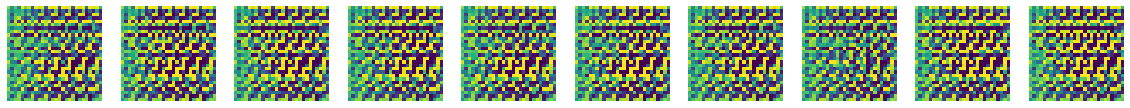

In [43]:
try:
    mygan = GAN(noise_shape=(256,))
    mygan.train(X, 16, exp)
except KeyboardInterrupt:
    sample_gen(mygan, 10)

In [44]:
exp.stop()